# Track the Voids
Determine which voids in each image are the same

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks, compute_drift
from pathlib import Path
import trackpy as tp
import pandas as pd
import numpy as np

Configuration

In [2]:
run_path = Path('data/drift-corrected-625C/')

## Load in the defect information
The `rtdefects` command-line application generates a JSON file with the positions and sizes of each void detected in each frame.

Our first step is to load that JSON into memory

In [3]:
void_data = pd.read_json(run_path / 'frames/masks/defect-details.json', lines=True).sort_values("image-path", ignore_index=True)
void_data['frame'] = np.arange(len(void_data))
print(f'Loaded defects from {len(void_data)} frames')

Loaded defects from 339 frames


Save the processed version too

In [4]:
void_data.to_json(run_path / 'frame_data.json')

## Show that we've detected void growth
Without tracking individual voids, we can see that they are growing in size and number

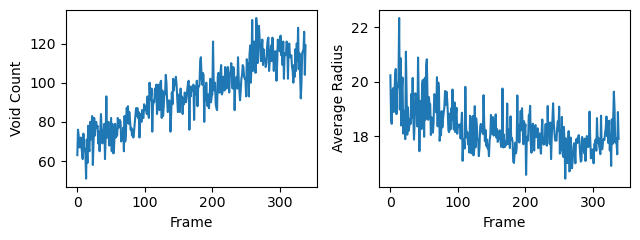

In [5]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6.5, 2.5))

axs[0].plot(void_data.index, void_data['void_count'])
axs[0].set_ylabel('Void Count')

axs[1].plot(void_data.index, void_data['radii_average'])
axs[1].set_ylabel('Average Radius')

for ax in axs:
    ax.set_xlabel('Frame')
    
fig.tight_layout()

We can see that we are detecting at least a dozen void per frame. Both the number and size increase with time.

There are many frames at the end where we don't detect any defects. Let's eliminate thsoe from the analysis.

In [6]:
void_data.query('void_count > 0', inplace=True, )
print(f'Reduced to {len(void_data)} frames with at least 1 void.')

Reduced to 339 frames with at least 1 void.


## Remove drift and then re-detect voids
This video has the defects removed, so we can compute void displacement with ease

In [7]:
%%time
particles = pd.concat(list(convert_to_per_particle(void_data)))
initial_tracks = tp.link_df(particles, search_range=8, memory=8)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles')

Frame 338: 119 trajectories present.
Found a total of 1589 unique particles
CPU times: user 494 ms, sys: 50 ms, total: 544 ms
Wall time: 504 ms


Note how we fewer unique voids this time! Things that initially "moved" too far to detect because of the camera drift are now associated together.

In [8]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,radii,max_radius,min_radius,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,growth_rate
0,0,0,1,0,"[[3.76271186440678, 745.3389830508474]]",[0],[8.667244841319219],8.667245,8.667245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,158,159,73,"[[493.65269461077844, 266.8922155688623], [492...","[34, 38, 41, 34, 34, 37, 32, None, None, None,...","[14.581872443920643, 12.463355264843006, 13.35...",14.581872,8.058239,"[0.0, 1.233511326228913, 2.0486717211757415, 2...",16.633257,0.104612,"[0.0, 1.233511326228913, 2.2319189785822275, 3...",115.163581,0.724299,0.002482
2,0,338,339,0,"[[529.3502170767005, 650.6801736613603], [529....","[35, 39, 42, 35, 35, 39, 34, 35, 31, 36, 35, 3...","[29.661566469288122, 30.172276587716105, 30.81...",43.861885,29.661566,"[0.0, 0.3232884173724153, 0.5621338615533008, ...",2.951186,0.008706,"[0.0, 0.3232884173724153, 0.5928811574011023, ...",268.091302,0.790830,0.035738
3,0,6,7,4,"[[534.2560975609756, 988.780487804878], [534.1...","[36, 41, None, None, None, None, 35]","[10.217907939900583, 10.823032759612019, 10.63...",10.823033,9.901487,"[0.0, 0.16491907591475458, 0.3602310386361187,...",1.141482,0.163069,"[0.0, 0.16491907591475458, 0.3602320684449002,...",1.141484,0.163069,-0.184309
4,0,338,339,0,"[[590.5560916767189, 171.6037394451146], [591....","[37, 44, 44, 38, 37, 41, 39, 37, 34, 39, 37, 3...","[45.9459591821838, 46.26354585091602, 46.09812...",55.920268,45.318157,"[0.0, 1.1375762197095738, 0.8821273682991589, ...",1.962989,0.005791,"[0.0, 1.1375762197095738, 2.0359433438026455, ...",257.535909,0.759693,0.028746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,338,338,1,0,"[[534.2089552238806, 430.9850746268657]]",[68],[9.23618154310838],9.236182,9.236182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585,338,338,1,0,"[[956.5222222222222, 144.34444444444443]]",[116],[10.704744696916627],10.704745,10.704745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586,338,338,1,0,"[[895.2727272727273, 231.61363636363637]]",[112],[10.585134856802455],10.585135,10.585135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1587,338,338,1,0,"[[780.3157894736842, 706.3684210526316]]",[96],[8.51907589177983],8.519076,8.519076,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
void_tracks.to_json(run_path / 'void_tracks.json')